### UNSUPERVISED MACHINE LEARNING FOR THE CLASSIFICATION OF ASTROPHYSICAL X-RAY SOURCES

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.spatial.distance import euclidean, cdist
from scipy.special import softmax
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools
from imblearn.over_sampling import SMOTE, ADASYN

In [2]:
sim_data = pd.read_csv('./crossmatch_gwu.csv', index_col=0)
sim_data.drop(columns='col1_2', inplace=True)
sim_data.rename(columns={'Class':'main_type', 'name_1':'name'}, inplace=True)

In [3]:
print('Classes in this dataset:', sim_data.main_type.unique())

Classes in this dataset: ['YSO' 'HMXB' 'AGN' 'LMXB' 'LM-STAR' 'NS_BIN' 'CV' 'HM-STAR' 'NS' nan]


In [4]:
print('Number of sources in this dataset: ', len(np.unique(sim_data['name'])))

Number of sources in this dataset:  15248


In [5]:
sim_df_clean = sim_data.copy(deep=True).fillna({'main_type': 'NaN'})

<AxesSubplot:>

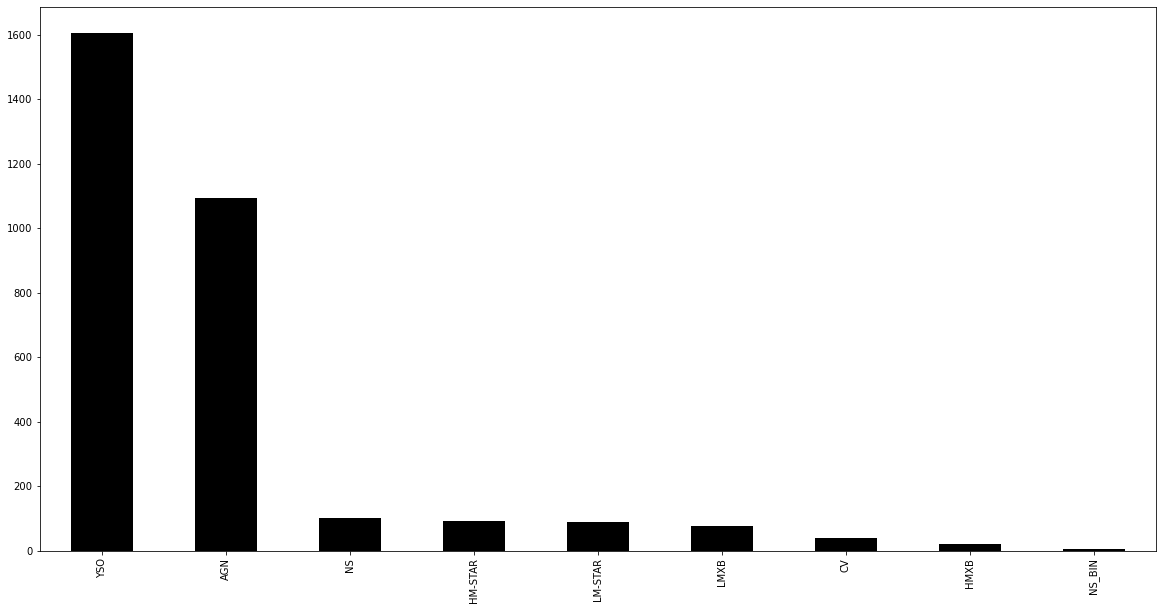

In [79]:
plt.figure(figsize=(20,10))
df_for_dist = sim_df_clean[(sim_df_clean.main_type != 'NaN') & ~(sim_df_clean.main_type.isin(uks))]
df_for_dist['main_type'].value_counts().plot.bar(color='black')

In [6]:
print('Number of source detections for each class:\n', sim_df_clean.main_type.value_counts())

Number of source detections for each class:
 NaN        26526
YSO         1606
AGN         1095
NS           103
HM-STAR       92
LM-STAR       89
LMXB          78
CV            40
HMXB          21
NS_BIN         5
Name: main_type, dtype: int64


In [7]:
features = ['hard_hm', 'hard_hs', 'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b','var_ratio_b', 'var_prob_h', 'var_ratio_h', 'var_prob_s', 'var_ratio_s', 'var_newq_b']

features_lognorm = ['bb_kt', 'var_ratio_b', 'var_ratio_s', 'var_newq_b']

features_norm = ['powlaw_gamma']

X = sim_df_clean.copy(deep=True).to_numpy()

In [8]:
# FUNCTION lognorm
# Apply log transform adding the minimum non-zero value divided by ten in order to preserve zero properties, then normalize.
# INPUT:
# X_df = data array
# X = data array as np array
# name_desc = string, name of the descriptor
# log = boolean, True if apply log transform before norm

# PROCEDURE:
# Modifies X np array of data with the normalizated data
def lognorm(X_df, X, name_desc, log):
    
    col = X_df.columns.get_loc(name_desc)
    X_desc = X_df[name_desc]
    
    if log:
        nonzero = X_desc[X_desc!=0]
        minval = np.min(nonzero)/10

        # print(minval)
        X_desc = X_desc + minval

        x = np.log(X_desc.values)  #returns a numpy array
    else:
        x = X_desc.to_numpy()
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    X[:,col] = x_scaled.flatten()
    
    return X

In [9]:
# Log transformation

for feature in features_lognorm:
    X = lognorm(sim_df_clean, X, feature, True)
        
for feature in features_norm:
    X = lognorm(sim_df_clean, X, feature, False)

In [10]:
s_df = pd.DataFrame(X, columns=sim_df_clean.columns)

In [11]:
def Mahalanobis(x, covariance_matrix, mean):

    x = np.array(x)
    mean = np.array(mean)
    covariance_matrix = np.array(covariance_matrix)

    t1 = (x-mean)
    #print(f'Term 1 {t1}')

    icov = np.linalg.inv(covariance_matrix)
    #print(f'Inverse covariance {icov}')

    t2 = (x.transpose()-mean.transpose())
    #print(f'Term 2 {t2}')

    mahal = t1.dot(icov.dot(t2))

    #return (x-mean)*np.linalg.inv(covariance_matrix).dot(x.transpose()-mean.transpose())
    return mahal

In [42]:
def create_summary_tables(df):
    data_n = df.copy(deep=True)
    count_obs = data_n.groupby(['main_type']).size()
    df_n = pd.concat([count_obs], axis=1)
    df_n = df_n.rename(columns={0:'size'})
    return df_n

def softmin(x):
    return np.exp(-np.abs(x))/sum(np.exp(-np.abs(x)))
    
def frequent_types(df, n, uks):
    if uks:
        df = df[(df.main_type != 'NaN') & ~(df.main_type.isin(uks))]
    else:
        df = df[df.main_type != 'NaN']
    count_obs = df.groupby(['main_type']).size()
    count_obs_df = count_obs.reset_index()
    count_obs_df = count_obs_df.rename(columns={0:'size'})
    quer = count_obs_df.sort_values(by='size', ascending=False).head(n)
    ltypes = np.unique(quer.main_type)
    return ltypes

def gen_nan_probs(cl, features, ltypes_in=[], uks=[], mean=True, distance='mahalanobis', predominants='cluster', num_pred=5):
    if uks:
        cl_nan = cl[(cl.main_type == 'NaN') | cl.main_type.isin(uks)]
    else:
        cl_nan = cl[cl.main_type == 'NaN']
        
    if predominants=='cluster':
        ltypes = frequent_types(s_df, num_pred, uks=uks)
    elif predominants=='general':
        ltypes = ltypes_in

    cl_types_desc = cl_nan[features]
    types_comp = []
    types_prob = []
    final_types = []
    first = True
    for i, row in cl_types_desc.iterrows():
        r_np = row.to_numpy().reshape(1, -1)
        
        mdists = []
        for t in ltypes:
            cl_type = cl[cl.main_type == t]
            cl_type_desc = cl_type[features]
            cltd_np = cl_type_desc.to_numpy()
            
            if cltd_np.shape[0] < len(features):
                continue
            if first:
                final_types.append(t)
                
            if distance == 'euclidean':
                d2t = cdist(r_np, cltd_np, metric='euclidean')
            elif distance == 'mahalanobis':
                #print(cltd_np.astype(float))
                V = np.cov(cltd_np.astype(float).T)
                
                IV = np.linalg.inv(V)

                mean_cltd = np.mean(cltd_np)
                
                #d2t = Mahalanobis(r_np, IV, mean_cltd)
                d2t = cdist(r_np, cltd_np, metric='mahalanobis', VI=IV)
            
            if mean:
                d2t_mean = np.mean(d2t)
            else:
                d2t_mean = np.median(d2t)

            mdists.append(d2t_mean)
        if first:
            first = False
        mdistsn = np.asarray(mdists).reshape(-1, 1)
        mdistsn = mdistsn.ravel()
        sm_probs = softmin(mdistsn)
        types_prob.append(sm_probs)
        t_amax = np.argmax(sm_probs)
        types_comp.append(final_types[t_amax])

    #print(cl_nan.name.to_numpy(), np.array(types_prob), types_comp)
    out_l = pd.DataFrame(cl_nan[['name', 'obsid'] + features])
    out_l['main_type'] = types_comp
    for i, t in enumerate(final_types):
        tarray_probs = np.vstack(types_prob)
        out_l[t] = tarray_probs[:, i]
        
    return out_l

In [14]:
# Dropping all NaNs and dummy classes
def process_data_for_validation(data, types, uks):
    if uks:
        df = data[(data.main_type != 'NaN') & ~(data.main_type.isin(uks))]
    else:
        df = data[data.main_type != 'NaN']
    df = df.loc[df['main_type'].isin(types)]
    return df

#### Experiment with normal classifier

In [20]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC

ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(data_clean, data_clean.main_type)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, stratify=y_resampled, random_state=42)

[('AGN', 1606), ('CV', 1606), ('HM-STAR', 1606), ('HMXB', 1606), ('LM-STAR', 1606), ('LMXB', 1606), ('NS', 1606), ('YSO', 1606)]


In [34]:
from collections import Counter
print(sorted(Counter(y_test).items()))

[('AGN', 482), ('CV', 481), ('HM-STAR', 482), ('HMXB', 482), ('LM-STAR', 482), ('LMXB', 482), ('NS', 482), ('YSO', 482)]


In [35]:
clf = LinearSVC(max_iter=3000)
clf.fit(X_resampled[features], y_resampled)

C:\Users\samue\miniconda3\envs\astrox\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC(max_iter=3000)

Text(87.0, 0.5, 'True')

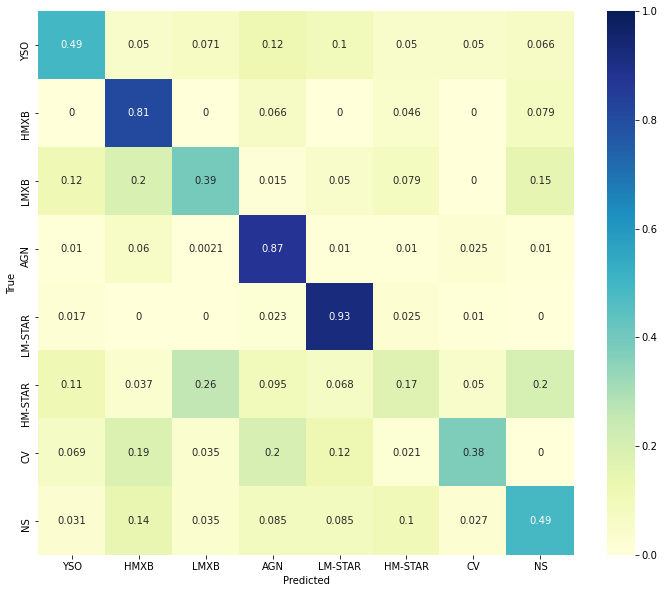

In [37]:
cf_matrix = confusion_matrix(y_test, clf.predict(X_test[features]), normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

#### With our classifier

### Selected classes

In [63]:
uks = ['Star', 'X', 'Unknown']
ltypes = ['YSO', 'HMXB', 'LMXB', 'AGN', 'LM-STAR', 'HM-STAR', 'CV', 'NS']
data_clean = process_data_for_validation(s_df, ltypes, uks=uks)
X_train, X_test, y_train, y_test = train_test_split(data_clean, data_clean.main_type, test_size=0.3, stratify=data_clean.main_type, random_state=42)
y_test_master = X_test.groupby(['name', 'main_type'], as_index=False).size()
y_test_master = y_test_master
y_test_sorted = X_test.sort_values(by=['name', 'obsid']).main_type
X_test.loc[:,'main_type'] = 'NaN'

C:\Users\samue\miniconda3\envs\astrox\lib\site-packages\pandas\core\indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [39]:
X_train.shape

(2186, 73)

In [40]:
X_test.shape

(938, 73)

In [43]:
pred_class = []
for cl_i in range(6):
    X_train_cl = X_train[X_train.cluster == cl_i]
    X_test_cl = X_test[X_test.cluster == cl_i]
    test_cl_class = gen_nan_probs(pd.concat([X_train_cl, X_test_cl]), features, ltypes, uks=uks, mean=True, distance='mahalanobis', predominants='general')
    pred_class.append(test_cl_class)
    
pred_class_df = pd.concat(pred_class)

#### Selecting high probabilities in classification

In [48]:
pred_class_df.sort_values(by=['name', 'obsid'], inplace=True)
prob_mask = pred_class_df.iloc[:,pred_class_df.columns.get_loc('main_type')+1:-2].max(axis=1) > 0.1
pred_class_certain = pred_class_df[prob_mask.to_numpy()]
y_test_certain = y_test_sorted[prob_mask.to_numpy()]

In [49]:
pred_class_certain.shape

(896, 21)

In [50]:
(pred_class_certain['main_type'] == 'CV').sum()

0

Text(87.0, 0.5, 'True')

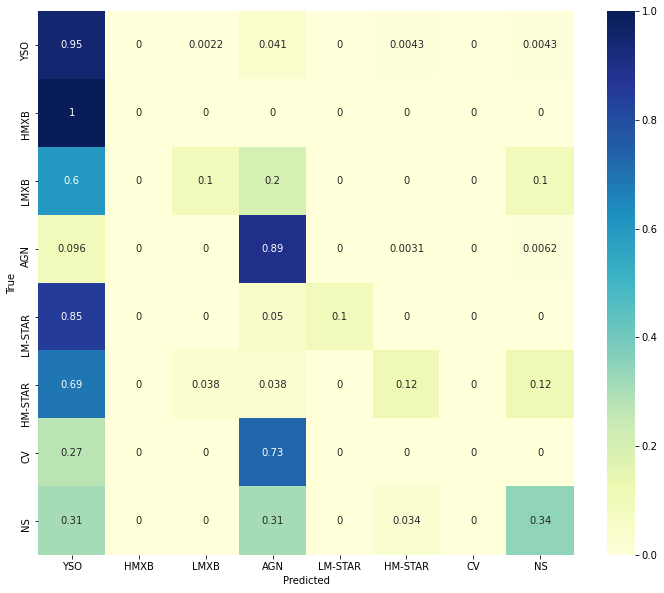

In [51]:
cf_matrix = confusion_matrix(y_test_certain, pred_class_certain.main_type, normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

#### Taking the raw test set

In [52]:
y_test_sorted.unique()

array(['AGN', 'CV', 'LM-STAR', 'NS', 'YSO', 'LMXB', 'HM-STAR', 'HMXB'],
      dtype=object)

In [53]:
pred_class_df.main_type.unique()

array(['AGN', 'YSO', 'LM-STAR', 'HM-STAR', 'LMXB', 'NS'], dtype=object)

In [54]:
print(classification_report(y_test_sorted, pred_class_df.sort_values(by=['name', 'obsid']).main_type))

              precision    recall  f1-score   support

         AGN       0.87      0.88      0.88       329
          CV       0.00      0.00      0.00        12
     HM-STAR       0.43      0.11      0.17        28
        HMXB       0.00      0.00      0.00         6
     LM-STAR       1.00      0.07      0.14        27
        LMXB       0.50      0.09      0.15        23
          NS       0.53      0.32      0.40        31
         YSO       0.80      0.95      0.87       482

    accuracy                           0.81       938
   macro avg       0.52      0.30      0.32       938
weighted avg       0.79      0.81      0.78       938



C:\Users\samue\miniconda3\envs\astrox\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(87.0, 0.5, 'True')

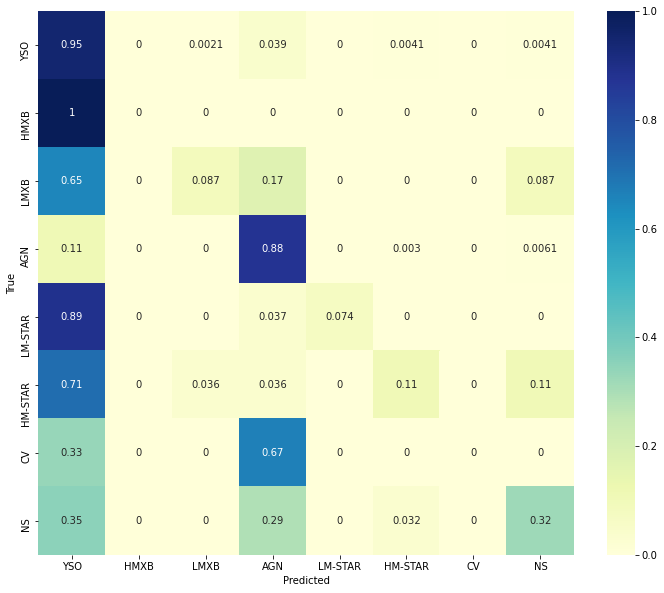

In [55]:
cf_matrix = confusion_matrix(y_test_sorted, pred_class_df.sort_values(by=['name', 'obsid']).main_type, normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')

#### Predominance with mean probabilities over observations

In [65]:
classes_names = pred_class_df.iloc[:,pred_class_df.columns.get_loc('main_type')+1:-2].columns
pred_class_df.fillna(0, inplace=True)
summ_table = pred_class_df.groupby('name')[classes_names].agg(['mean', 'std'])
summ_table['count'] = pred_class_df.groupby(['name']).size()
class_mean_names = [list(tup) for tup in itertools.product(classes_names, ['mean'], repeat=1)]
names_comp = summ_table[class_mean_names].idxmax(axis=1).to_list()
master_names = [name[0] for name in names_comp]
summ_table['master_names'] = master_names

In [66]:
y_true = y_test_master.sort_values(by='name').main_type
y_pred = summ_table.sort_values(by='name').master_names

In [67]:
y_true

0      AGN
1      AGN
2      AGN
3      AGN
4       CV
      ... 
521    AGN
522    AGN
523    AGN
524    AGN
525    AGN
Name: main_type, Length: 526, dtype: object

Text(87.0, 0.5, 'True')

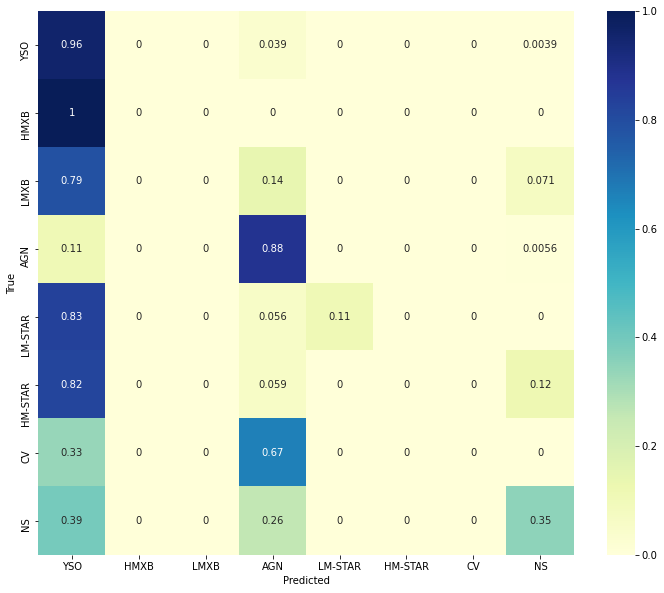

In [68]:
cf_matrix = confusion_matrix(y_true, y_pred, normalize='true', labels=ltypes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(cf_matrix, annot=True, xticklabels = ltypes, yticklabels = ltypes, ax=ax, vmin=0, vmax=1, cmap="YlGnBu")
ax.set_xlabel('Predicted')
ax.set_ylabel('True')